In [81]:
#establish STAC search, just like with previous notebooks
#setup band mapping for spyndex
#generate example indices to test process works
#save out geotifs of indices

In [82]:
#%pip install spyndex -q
#%pip install odc-stac -q
#%pip install stackstac -q

In [83]:
import pandas
import numpy as np
import xarray as xr
import geopandas as gpd
import rasterio
from rasterio.windows import Window
from rasterio.windows import from_bounds
from rasterio import plot
from rasterio.plot import show
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pystac_client

import spyndex
import odc.stac
from odc.stac import configure_rio, stac_load
import stackstac


In [84]:
def initialize_stac_client(stac_url):
    """
    Initialize and return a STAC client for a given STAC API URL.
    Parameters:
    - stac_url (str): The URL of the STAC API.
    Returns:
    - A pystac_client.Client object
    """
    client = pystac_client.Client.open(stac_url)
    return client


def query_stac_api_return_collection(client, collections, bbox, start_date=None, end_date=None, max_items=10):
    """
    Query a STAC API for items within a bounding box and date range for specific collections.
    Parameters:
    - client: The STAC client initialized with `initialize_stac_client`.
    - bbox (list): The bounding box for the query [min_lon, min_lat, max_lon, max_lat].
    - collections (list): A list of collection IDs to include in the query.
    - start_date (str, optional): The start date for the query (YYYY-MM-DD). Defaults to None.
    - end_date (str, optional): The end date for the query (YYYY-MM-DD). Defaults to None.
    - limit (int): Maximum number of items to return.    
    Returns:
    - A list of STAC Items that match the query parameters.
    """

    search_params = {
        "bbox": bbox,
        "collections": [collections],
        "max_items": max_items
    }
    if start_date and end_date:
        search_params["datetime"] = f"{start_date}/{end_date}"

    search = client.search(**search_params).item_collection()

    return search



In [85]:
def stac_items_to_array():
    pass

In [86]:
geom_fpath = '/workspaces/data-notebooks/notebooks/sandbox/data/input-data/dissolved-boundaries.geojson'
geom = gpd.read_file(geom_fpath)

bbox = list(geom.total_bounds)
lat = geom.centroid.x[0]
long = geom.centroid.y[0]

stac_url_sentinel = "https://earth-search.aws.element84.com/v1"
collection_sentinel = "sentinel-2-l2a"

start_date = "2023-01-01"
end_date = "2023-04-01"

client_sentinel = initialize_stac_client(stac_url_sentinel)


/tmp/ipykernel_48647/74160282.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat = geom.centroid.x[0]
/tmp/ipykernel_48647/74160282.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  long = geom.centroid.y[0]


In [87]:
items_sentinel = query_stac_api_return_collection(client_sentinel, collection_sentinel, bbox, start_date, end_date)

In [88]:
# from the above collection of STAC items, only get the red and nir bands, resample to 30m, and only get pixels that fall within the bbox provided.
stack = stackstac.stack(items_sentinel,
                        assets = ['blue','green','red','nir'],
                        bounds_latlon=bbox)
stack

/opt/conda/lib/python3.11/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray 'stackstac-2b7a7d5722d5a88562f40cd622f49284' (time: 10,
                                                                band: 4,
                                                                y: 973, x: 1245)> Size: 388MB
dask.array<fetch_raster_window, shape=(10, 4, 973, 1245), dtype=float64, chunksize=(1, 1, 973, 1024), chunktype=numpy.ndarray>
Coordinates: (12/54)
  * time                                     (time) datetime64[ns] 80B 2023-0...
    id                                       (time) <U24 960B 'S2B_50JMN_2023...
  * band                                     (band) <U5 80B 'blue' ... 'nir'
  * x                                        (x) float64 10kB 4.281e+05 ... 4...
  * y                                        (y) float64 8kB 6.767e+06 ... 6....
    s2:nodata_pixel_percentage               int64 8B 0
    ...                                       ...
    title                                    (band) <U20 320B 'Blue (band 2) ...
    gsd                                      int64 8B 10
    common_name                              (band) <U5 80B 'blue' ... 'nir'
    center_wavelength                        (band) float64 32B 0.49 ... 0.842
    full_width_half_max                      (band) float64 32B 0.098 ... 0.145
    epsg                                     int64 8B 32750
Attributes:
    spec:        RasterSpec(epsg=32750, bounds=(428080.0, 6757730.0, 440530.0...
    crs:         epsg:32750
    transform:   | 10.00, 0.00, 428080.00|\n| 0.00,-10.00, 6767460.00|\n| 0.0...
    resolution:  10.0

Use the Spyndex package to map satellite bands to parameters, and then calculate whatever indices we want. 

In [89]:
lowcloud = stack[stack["eo:cloud_cover"] < 20]
monthly = lowcloud.resample(time="MS").median("time", keep_attrs=True)
rgb = monthly.sel(band=["red", "green", "blue"])
rgb

<xarray.DataArray 'stackstac-2b7a7d5722d5a88562f40cd622f49284' (time: 2,
                                                                band: 3,
                                                                y: 973, x: 1245)> Size: 58MB
dask.array<getitem, shape=(2, 3, 973, 1245), dtype=float64, chunksize=(1, 3, 973, 1245), chunktype=numpy.ndarray>
Coordinates: (12/29)
  * band                                     (band) <U5 60B 'red' 'green' 'blue'
  * x                                        (x) float64 10kB 4.281e+05 ... 4...
  * y                                        (y) float64 8kB 6.767e+06 ... 6....
    s2:nodata_pixel_percentage               int64 8B 0
    s2:saturated_defective_pixel_percentage  int64 8B 0
    mgrs:latitude_band                       <U1 4B 'J'
    ...                                       ...
    gsd                                      int64 8B 10
    common_name                              (band) <U5 60B 'red' 'green' 'blue'
    center_wavelength                        (band) float64 24B 0.665 0.56 0.49
    full_width_half_max                      (band) float64 24B 0.038 ... 0.098
    epsg                                     int64 8B 32750
  * time                                     (time) datetime64[ns] 16B 2023-0...
Attributes:
    spec:        RasterSpec(epsg=32750, bounds=(428080.0, 6757730.0, 440530.0...
    crs:         epsg:32750
    transform:   | 10.00, 0.00, 428080.00|\n| 0.00,-10.00, 6767460.00|\n| 0.0...
    resolution:  10.0

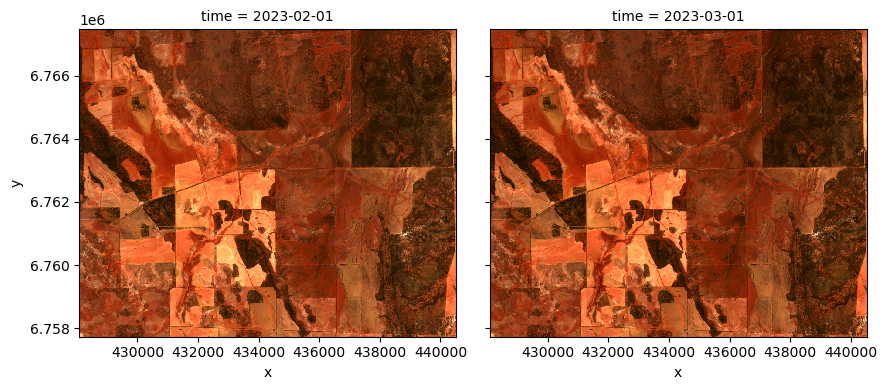

In [90]:
rgb.plot.imshow(col="time", rgb="band", robust=True, size=4);

In [91]:
# using the data array set up using stackstac, we can now comput a bunch of indices:
monthly['NDVI'] = spyndex.computeIndex(
    index=['NDVI'],
    params={
        "N":monthly.sel(band="nir"),
        "R":monthly.sel(band="red")
    }
)

In [92]:
monthly["GNDVI"] = spyndex.computeIndex(
    index=["GNDVI"],
    params={
        "N":monthly.sel(band="nir"),
        "G":monthly.sel(band="green")
    }
)

In [93]:
# Use the computeKernel() method to compute the required kernel for kernel indices like the kNDVI
# Kernel Normalized Difference Vegetation Index
parameters = {
    "kNN": 1.0,
    "kNR": spyndex.computeKernel(
        kernel="RBF",
        params={"a": monthly.sel(band="nir") , "b": monthly.sel(band="red"), "sigma": 0.5 * (monthly.sel(band="nir") + monthly.sel(band="red"))},
    ),
}
monthly["kNDVI"] = spyndex.computeIndex("kNDVI", parameters)

/opt/conda/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/opt/conda/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


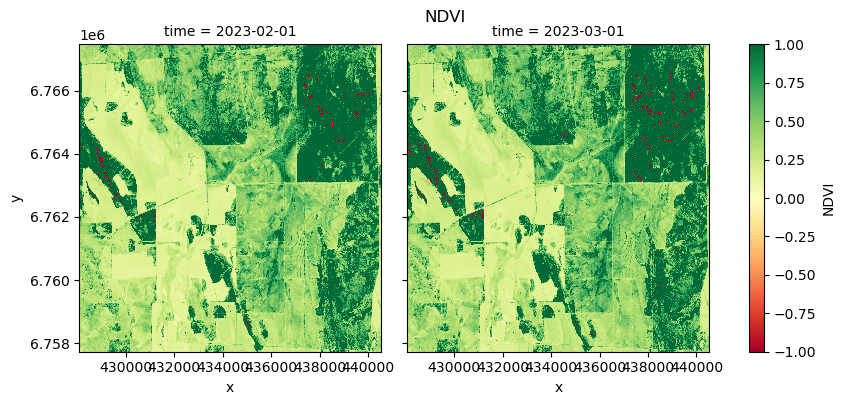

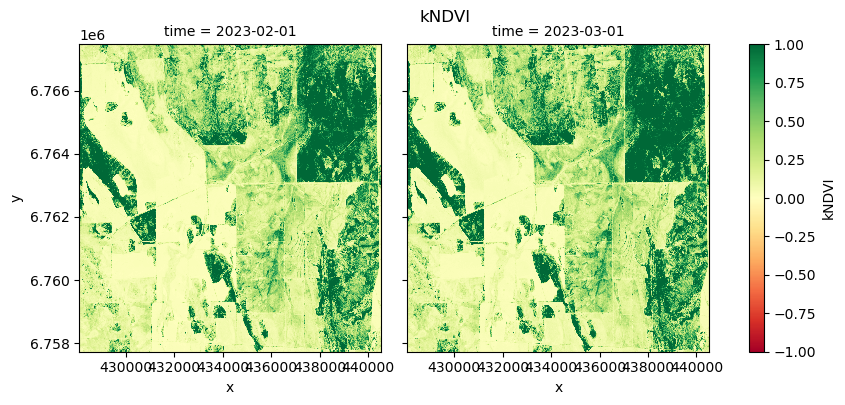

In [98]:
fig_ndvi = monthly.NDVI.clip(-1,1).plot(col="time", cmap="RdYlGn", vmin=-1, vmax=1, size=4)
fig_ndvi.fig.suptitle("NDVI", y= 1.0)

fig_gndvi = monthly.GNDVI.clip(-1,1).plot(col="time", cmap="RdYlGn", vmin=-1, vmax=1, size=4)
fig_gndvi.fig.suptitle("GNDVI", y= 1.0)

fig_kndvi = monthly.kNDVI.clip(-1,1).plot(col="time", cmap="RdYlGn", vmin=-1, vmax=1, size=4)
fig_kndvi.fig.suptitle("kNDVI", y= 1.0)
plt.show()

In [97]:
print(spyndex.indices["NDVI"])
print(spyndex.indices["GNDVI"])
print(spyndex.indices["kNDVI"])

NDVI: Normalized Difference Vegetation Index
        * Application Domain: vegetation
        * Bands/Parameters: ['N', 'R']
        * Formula: (N-R)/(N+R)
        * Reference: https://ntrs.nasa.gov/citations/19740022614
        
GNDVI: Green Normalized Difference Vegetation Index
        * Application Domain: vegetation
        * Bands/Parameters: ['N', 'G']
        * Formula: (N-G)/(N+G)
        * Reference: https://doi.org/10.1016/S0034-4257(96)00072-7
        
kNDVI: Kernel Normalized Difference Vegetation Index
        * Application Domain: kernel
        * Bands/Parameters: ['kNN', 'kNR']
        * Formula: (kNN-kNR)/(kNN+kNR)
        * Reference: https://doi.org/10.1126/sciadv.abc7447
        
